# Task4 

### use pipline and grid search to find best parameter for different models (SVM,random forest,KNN)


In [23]:
# import data and packages
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# simple EDA to this dataset

df = pd.read_csv("./Dataset/seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
# Accroding to the dataset, we can know that the 'type' is classify target and others are predictors
# So we can have a look on majority type
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

In [4]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

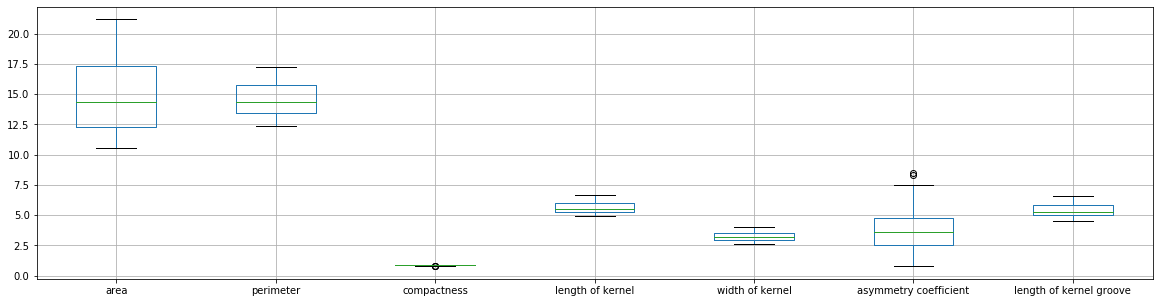

In [5]:
# don't have any empty value in dataset, and we have 3 types each have 70 instance
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

the asymmetry coefficient has most prominent outliner
Log transformation and RobustScaler will apply later

## Data preparation 


In [6]:
df['asymmetry coefficient'] = np.log(df['asymmetry coefficient'])

In [11]:
# store a list of column names except 'type'
names_all  = [c for c in df if c not in ['type']]

#prepare the name of  outlier and else
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outlier))

In [12]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    # add column name
    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [13]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("Does not include this column : %s" % cols_error)

# prepare the pipeline

In [17]:

preproces_pipeline = make_pipeline(
    AddColumnNames(columns = names_all),
    FeatureUnion(transformer_list = [
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            MinMaxScaler()
        ))]
        )
)

In [18]:
# split the data from test and train
# we know the type colum means the result so y is the type and x is cases without type
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

# Train model by SVM , random forest and KNN with para-grid


In [20]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preproces_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.942:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'linear'}


In [28]:
# Now try the random forest
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preproces_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.937:
Best parameters:  {'rf__max_depth': 8, 'rf__n_estimators': 10}


In [29]:
# Now try the KNN
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preproces_pipeline), ('knn', KNeighborsClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'knn__n_neighbors' : [4,5,7]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.910:
Best parameters:  {'knn__n_neighbors': 7}


## Compare Classifiers on Test Set

In [26]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [33]:
def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
   # _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    #_tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
   # _auc = auc(_fpr, _tpr)
            
   # return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc
    return _accuracy, _precision[0], _recall[0], _f1_score[0]

In [34]:
#Now put SVM,RF and KNN in
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score= evaluate_model(X_test, y_test, RF_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score = evaluate_model(X_test, y_test, KNN_best_model)

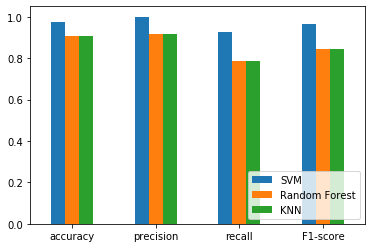

In [35]:
# draw !
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,'KNN':KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Accroding the graph we can know among all metrics, SVM outperform other models

In [37]:
## Train a Final Model
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preproces_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

In [38]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))